In [1]:
"""
Script to render the asset pricing table
"""

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp
from regtabletotext import prettify_result
import warnings
warnings.filterwarnings("ignore")

from environ.constants import (
    DEPENDENT_VARIABLES,
    DEPENDENT_VARIABLES_ASSETPRICING,
    PROCESSED_DATA_PATH,
    STABLE_DICT,
    ALL_NAMING_DICT,
    TABLE_PATH,
)
from environ.process.asset_pricing.double_sorting import calculate_period_return
from environ.process.asset_pricing.assetpricing_functions import (
    reg_fama_macbeth, clean_weekly_panel, univariate_sort, univariate_sort_table, double_sort, double_sort_table, get_dominance_factor)
                                                                  


In [2]:
# load factors
ff3 = pd.read_csv(PROCESSED_DATA_PATH/"FF3.csv") 
ltw3 = pd.read_csv(PROCESSED_DATA_PATH/"LTW3.csv")

# load the regression panel dataset
reg_panel = pd.read_pickle(
    PROCESSED_DATA_PATH / "panel_main.pickle.zip", compression="zip"
)

# stable non-stable info dict
stable_nonstable_info = {
    "stablecoin": reg_panel[reg_panel["Token"].isin(STABLE_DICT.keys())],
    "non-stablecoin": reg_panel[~reg_panel["Token"].isin(STABLE_DICT.keys())],
    "all": reg_panel,
}

# How are returns aggregated for each portfolio
ret_agg = 'mean'

# DEPENDENT_VARIABLES_ASSETPRICING =['volume_ultimate_share']  #,'volume_in_share' , 'volume_out_share']
# ,'eigen_centrality_undirected','total_eigen_centrality_undirected','Volume_share']

### Betweeness charts

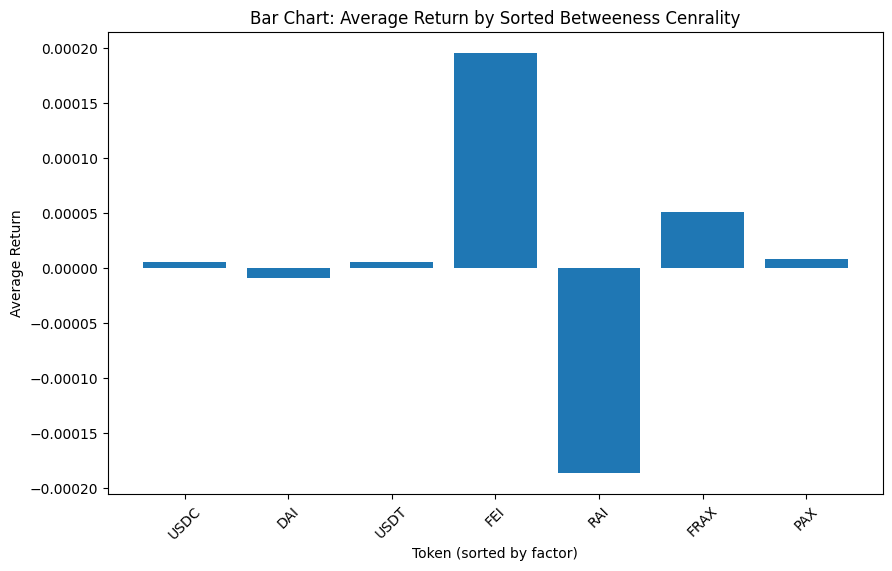

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dom_variable = 'betweenness_centrality_count'

df_panel = calculate_period_return(reg_panel[reg_panel.Token.isin(['USDT','USDC','DAI','FEI', 'RAI', 'FRAX', 'PAX'])],
    freq=1,
    date_col= "Date",
    daily_supply_rate_col= "supply_rates",
    simple_dollar_ret= -1)

df_panel["ret"] = df_panel.groupby(["Date"])['ret'].transform(lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))

# Compute average statistics by currency (used in multiple charts)
avg_stats = df_panel.groupby('Token').agg({'ret': 'mean', dom_variable: 'mean'}).reset_index()

# Sorted Bar Chart: Average Return by Sorted Dominance ------------------
# Sort currencies by average dominance (highest first)
avg_stats_sorted = avg_stats.sort_values(dom_variable, ascending=False)

plt.figure(figsize=(10,6))
plt.bar(avg_stats_sorted['Token'], avg_stats_sorted['ret'])
plt.xlabel('Token (sorted by factor)')
plt.ylabel('Average Return')
plt.title('Bar Chart: Average Return by Sorted Betweeness Cenrality')
plt.xticks(rotation=45)
plt.show()



### Univariate sorting

In [4]:
for dom_variable in DEPENDENT_VARIABLES_ASSETPRICING:
    for is_boom in [-1]:
        quantiles, separate_zero_value = [0,0.3,0.7,1], False #[0,0.9,0.95,1] #
        df_panel = clean_weekly_panel(reg_panel, is_stablecoin = 0, is_boom = is_boom)

        # Substract risk free rate
        df_panel = pd.merge(df_panel,ff3, on='WeekYear')
        df_panel['ret'] = df_panel['ret']-df_panel['RF']

        df_panel = univariate_sort(df_panel, dom_variable, quantiles=quantiles, separate_zero_value=separate_zero_value)
        summary_table = univariate_sort_table(df_panel, ret_agg = ret_agg)
    
        if is_boom == 1:
            boom_str = " boom"
        elif is_boom == 0:
            boom_str = " bust"
        else:
            boom_str = " alltime"
        summary_table = summary_table.style.set_caption(dom_variable+' '+boom_str)
        display(summary_table)

,P1,P2,P3,P3-P1
Mean,0.019116,0.008810,0.005646,-0.013470
t-Stat,1.609453,0.792199,0.604530,-2.033038
StdDev,0.137491,0.128728,0.108120,0.076695
Sharpe,1.003976,0.494173,0.377105,-1.268208


,P1,P2,P3,P3-P1
Mean,0.018127,0.013512,0.003537,-0.014590
t-Stat,1.556163,1.123259,0.387126,-2.169530
StdDev,0.134843,0.139249,0.105756,0.077850
Sharpe,0.970734,0.700688,0.241489,-1.353351


,P1,P2,P3,P3-P1
Mean,0.018620,0.010595,0.005894,-0.012726
t-Stat,1.593704,0.914212,0.634808,-1.937609
StdDev,0.135246,0.134158,0.107483,0.076027
Sharpe,0.994152,0.570285,0.395993,-1.208679


,P1,P2,P3,P3-P1
Mean,0.019404,0.009461,0.003877,-0.015527
t-Stat,1.628990,0.844091,0.429540,-2.283541
StdDev,0.137884,0.129743,0.104479,0.078708
Sharpe,1.016163,0.526543,0.267947,-1.424472


,P1,P2,P3,P3-P1
Mean,0.019214,0.011485,0.003661,-0.015553
t-Stat,1.612889,1.028116,0.402107,-2.273371
StdDev,0.137897,0.129316,0.105383,0.079194
Sharpe,1.006120,0.641338,0.250834,-1.418127


,P1,P2,P3,P3-P1
Mean,0.019620,0.006472,0.005046,-0.014573
t-Stat,1.647616,0.578644,0.549758,-2.122018
StdDev,0.137843,0.129467,0.106259,0.079498
Sharpe,1.027782,0.360958,0.342939,-1.323714


,P1,P2,P3,P3-P1
Mean,0.011256,0.006483,0.055262,0.044005
t-Stat,1.487584,0.497258,3.565519,3.816618
StdDev,0.087594,0.150923,0.179413,0.133468
Sharpe,0.927954,0.310189,2.224169,2.380804


In [5]:
df_panel.portfolio.value_counts()

portfolio
P2    2914
P1    2279
P3    2258
Name: count, dtype: int64

In [6]:
test = clean_weekly_panel(reg_panel, is_stablecoin = 0, is_boom = -1)
test.describe()

,ret,volume_ultimate_share,eigen_centrality_undirected,vol_inter_full_len_share,betweenness_centrality_volume,betweenness_centrality_count,total_eigen_centrality_undirected,Volume_share,volume_in_share,volume_out_share,mcap,amihud,ret_lead_1
count,31717.000000,31717.000000,31717.000000,31717.000000,31717.000000,31717.000000,31717.000000,31717.000000,31717.000000,31717.000000,3.171700e+04,7.451000e+03,31717.000000
mean,0.002189,0.004126,0.009530,0.004207,0.001994,0.002726,0.009403,0.004133,0.004133,0.004133,1.789099e+09,9.693595e-06,0.004515
std,0.235466,0.033640,0.063393,0.047683,0.033558,0.041681,0.063652,0.034300,0.034246,0.034371,1.823303e+10,2.443119e-04,0.238711
min,-0.800279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.800279
25%,-0.114990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.019431e+06,8.541736e-09,-0.114536
50%,-0.011518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.042572e+07,3.372519e-08,-0.011403
75%,0.070594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.924121e+08,1.145171e-07,0.072440
max,4.410082,0.467854,0.705255,0.993955,0.979208,0.977260,0.706829,0.495497,0.505160,0.514906,5.560275e+11,1.283550e-02,4.410082


In [7]:
df_panel.groupby('portfolio')['mcap'].median()

portfolio
P1    1.438855e+09
P2    1.761111e+08
P3    5.282951e+07
Name: mcap, dtype: float64

### Double sort

In [8]:
for secondary_variable in ['mcap']:
    for dom_variable in ['volume_ultimate_share'] #DEPENDENT_VARIABLES_ASSETPRICING:
        for is_boom in [-1]:
            quantiles, separate_zero_value = [0,0.3,0.7,1], False #[0,0.25,0.5,0.75,1] 
            df_panel = clean_weekly_panel(reg_panel, is_stablecoin = 0, is_boom = is_boom)
            df_panel = pd.merge(df_panel,ff3, on='WeekYear')
            df_panel= double_sort(df_panel, dom_variable, secondary_variable=secondary_variable, quantiles=quantiles, separate_zero_value=separate_zero_value)
            summary_table = double_sort_table(df_panel, ret_agg="mean")
            if is_boom == 1:
                boom_str = " boom"
            elif is_boom == 0:
                boom_str = " bust"
            else:
                boom_str = "alltime"
            summary_table = summary_table.style.set_caption(dom_variable +' '+ boom_str)
            display(summary_table)

SyntaxError: expected ':' (1706948765.py, line 2)

# Factor testing

In [ ]:
for dom_variable in DEPENDENT_VARIABLES_ASSETPRICING:
    for is_boom in [-1]:
        quantiles, separate_zero_value = [0,0.3,0.7,1], False
        df_panel = clean_weekly_panel(reg_panel, is_stablecoin = 0, is_boom = is_boom)
        # df_panel = df_panel[df_panel[dom_variable] > 0]
        df_panel = univariate_sort(df_panel,dom_variable, quantiles, separate_zero_value =separate_zero_value)
        dominance_factor = get_dominance_factor(df_panel)

        # merge all factors
        factors_data = pd.merge(dominance_factor, ff3, on=["WeekYear"], how="left")
        factors_data = pd.merge(factors_data, ltw3, on=["WeekYear"], how="left")
        # merge factors with returns
        factors_data = factors_data.dropna()
        # AP_CAPM= smf.ols(formula= 'CDOM ~ MKT', data=factors_data).fit()
        # prettify_result(AP_CAPM)
        AP_test_cmkt = smf.ols(formula= 'CDOM ~ CMKT', data=factors_data).fit()
        prettify_result(AP_test_cmkt)
        AP_test_ltw3 = smf.ols(formula= 'CDOM ~ CMKT + CMOM + CSIZE', data=factors_data).fit()
        prettify_result(AP_test_ltw3)
        print("CSIZE factor is long small cap and short large cap")

OLS Model:
CDOM ~ CMKT

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept    -0.012       0.007       -1.837    0.069
CMKT         -0.104       0.070       -1.484    0.140

Summary statistics:
- Number of observations: 134
- R-squared: 0.016, Adjusted R-squared: 0.009
- F-statistic: 2.203 on 1 and 132 DF, p-value: 0.140

OLS Model:
CDOM ~ CMKT + CMOM + CSIZE

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept    -0.008       0.007       -1.177    0.241
CMKT         -0.108       0.070       -1.548    0.124
CMOM         -0.096       0.098       -0.975    0.331
CSIZE        -0.144       0.097       -1.479    0.141

Summary statistics:
- Number of observations: 134
- R-squared: 0.040, Adjusted R-squared: 0.018
- F-statistic: 1.823 on 3 and 130 DF, p-value: 0.146

CSIZE factor is long small cap and short large cap


### FAMA MCBETH 

In [ ]:
for dom_variable in DEPENDENT_VARIABLES_ASSETPRICING:
    for is_boom in [-1]:
        quantiles, separate_zero_value = [0,0.3,0.7,1], False
        df_panel = clean_weekly_panel(reg_panel, is_stablecoin = 0, is_boom = is_boom)
        df_panel = univariate_sort(df_panel,dom_variable, quantiles, separate_zero_value =separate_zero_value)
        dominance_factor = get_dominance_factor(df_panel)
        #get the test assets
        assets_panel = clean_weekly_panel(reg_panel, is_stablecoin = 0, is_boom = -1)
        # merge all factors
        data_fama_macbeth = pd.merge(dominance_factor, ff3, on=["WeekYear"], how="left")
        data_fama_macbeth = pd.merge(data_fama_macbeth, ltw3, on=["WeekYear"], how="left")
        # merge factors with returns
        data_fama_macbeth = pd.merge(data_fama_macbeth, assets_panel, on=["WeekYear"], how="left")
        data_fama_macbeth = data_fama_macbeth.dropna()

        # run the Fama-Macbeth regression
        data_fama_macbeth['excess_ret'] = data_fama_macbeth['ret'] - data_fama_macbeth['RF']
        fama_macbeth = reg_fama_macbeth(data_fama_macbeth, formula="excess_ret ~ CMKT + CMOM + CSIZE + CDOM")
        if is_boom == 1:
            boom_str = " boom"
        elif is_boom == 0:
            boom_str = " bust"
        else:
            boom_str = " alltime"
        fama_macbeth = fama_macbeth.style.set_caption(dom_variable + boom_str)
        display(fama_macbeth)

,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,-0.236000,-2.180000,-1.874000
1,CMKT,0.873000,5.426000,5.694000
2,CMOM,0.039000,0.425000,0.415000
3,CSIZE,0.277000,3.089000,3.000000
4,Intercept,4.215000,3.358000,2.837000


,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,-0.233000,-2.173000,-1.888000
1,CMKT,0.873000,5.425000,5.693000
2,CMOM,0.038000,0.418000,0.409000
3,CSIZE,0.277000,3.088000,3.000000
4,Intercept,4.213000,3.357000,2.838000


,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,-0.208000,-1.894000,-1.663000
1,CMKT,0.874000,5.424000,5.689000
2,CMOM,0.039000,0.424000,0.414000
3,CSIZE,0.277000,3.089000,3.001000
4,Intercept,4.213000,3.358000,2.836000


,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,-0.226000,-2.049000,-1.785000
1,CMKT,0.873000,5.424000,5.690000
2,CMOM,0.038000,0.423000,0.413000
3,CSIZE,0.277000,3.090000,3.001000
4,Intercept,4.211000,3.356000,2.836000


,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,-0.221000,-2.008000,-1.778000
1,CMKT,0.874000,5.423000,5.690000
2,CMOM,0.038000,0.423000,0.413000
3,CSIZE,0.277000,3.089000,3.001000
4,Intercept,4.210000,3.355000,2.835000


,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,-0.216000,-1.917000,-1.611000
1,CMKT,0.873000,5.425000,5.692000
2,CMOM,0.038000,0.421000,0.412000
3,CSIZE,0.277000,3.090000,3.001000
4,Intercept,4.213000,3.359000,2.837000


,factor,risk_premium,t_stat,t_stat_NW
0,CDOM,0.530000,3.126000,2.531000
1,CMKT,0.863000,5.402000,5.670000
2,CMOM,0.036000,0.398000,0.391000
3,CSIZE,0.273000,3.066000,2.977000
4,Intercept,4.115000,3.313000,2.816000
